### Testing Out Some Basic Preprocessing

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
os.chdir('/Users/davidmiles-skov/Desktop/special_courses/materials_characterization/xrd_analysis/AutoXRD') # change working directory to root folder

metadata:
pattern_id            0.000000
ref_id1               8.000000
ref_id2               6.000000
noise_level           0.150000
peak_scale            3.000000
decay_rate            0.049628
x0                    6.659130
phase_shift_prob      0.215509
phase_shift_range    11.400030
Name: 0, dtype: float64


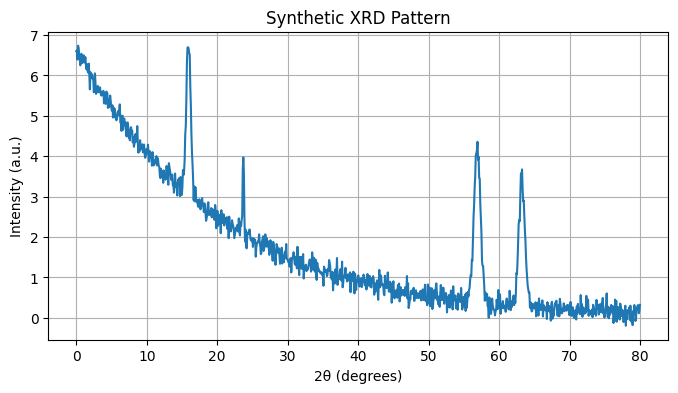

In [ ]:
# Load the data
data = np.load('data/synthetic_xrd_patterns.npy')
meta_data = pd.read_csv('data/synthetic_xrd_metadata.csv')

x_vals = np.linspace(0, 80, 1000)
xrd_data = data[0]

print(f"metadata:\n{meta_data.iloc[0]}")

# Extract metadata and plot reference patterns
# Plot first pattern and display metadata
plt.figure(figsize=(8, 4))
plt.plot(x_vals, xrd_data)
plt.title('Synthetic XRD Pattern')
plt.xlabel('2θ (degrees)')
plt.ylabel('Intensity (a.u.)')
plt.grid()
plt.show()

1. Normalising

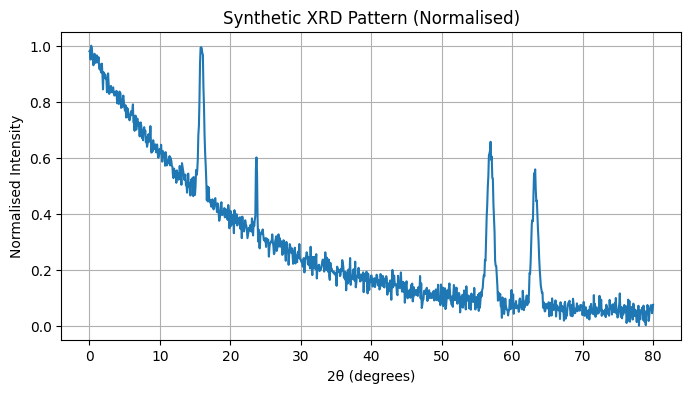

In [4]:
min_max_normalise = lambda x: (x - np.min(x, axis=1, keepdims=True)) / (np.max(x, axis=1, keepdims=True) - np.min(x, axis=1, keepdims=True))

# Normalise the data
data_normalised = min_max_normalise(data)

# Plot the normalised data
plt.figure(figsize=(8, 4))
plt.plot(x_vals, data_normalised[0])
plt.title('Synthetic XRD Pattern (Normalised)')
plt.xlabel('2θ (degrees)')
plt.ylabel('Normalised Intensity')
plt.grid()
plt.show()

2. Testing Different Smoothing Methods

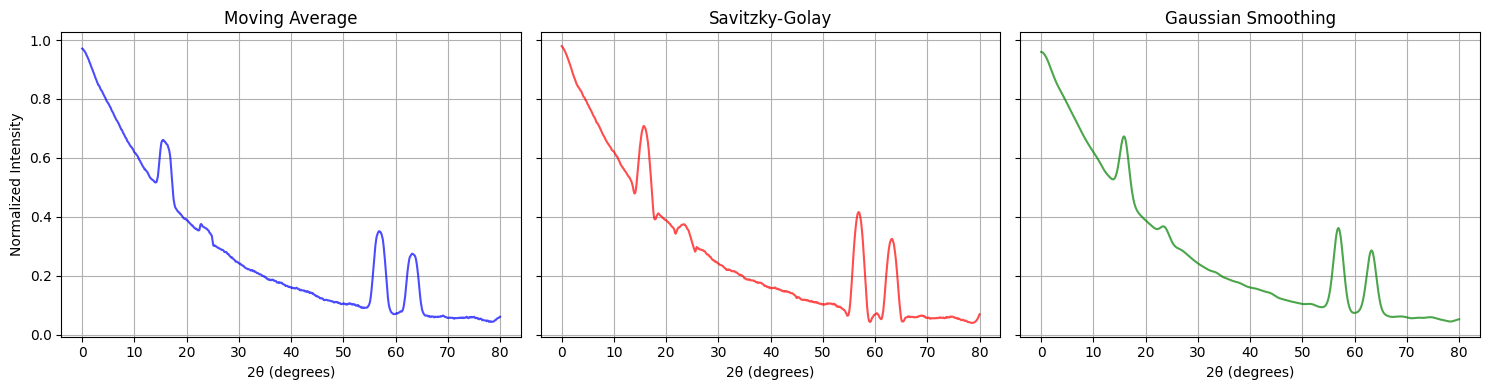

In [5]:
from utils.smooth import (
    moving_average_smooth,
    savgol_smooth,
    gaussian_smooth,
)

# Apply smoothing to the data
data_smoothed_ma = np.zeros_like(data_normalised)
data_smoothed_sg = np.zeros_like(data_normalised)
data_smoothed_gauss = np.zeros_like(data_normalised)

for i in range(data_normalised.shape[0]):
    data_smoothed_ma[i] = moving_average_smooth(data_normalised[i], window_size=30)
    data_smoothed_sg[i] = savgol_smooth(data_normalised[i], window_size=50, poly_order=3, mode='interp')
    data_smoothed_gauss[i] = gaussian_smooth(data_normalised[i], sigma=10)

# Create subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)

# Plot Moving Average Smoothing
axes[0].plot(x_vals, data_smoothed_ma[0], color='blue', alpha=0.7)
axes[0].set_title('Moving Average')
axes[0].set_xlabel('2θ (degrees)')
axes[0].set_ylabel('Normalized Intensity')
axes[0].grid()

# Plot Savitzky-Golay Smoothing
axes[1].plot(x_vals, data_smoothed_sg[0], color='red', alpha=0.7)
axes[1].set_title('Savitzky-Golay')
axes[1].set_xlabel('2θ (degrees)')
axes[1].grid()

# Plot Gaussian Smoothing
axes[2].plot(x_vals, data_smoothed_gauss[0], color='green', alpha=0.7)
axes[2].set_title('Gaussian Smoothing')
axes[2].set_xlabel('2θ (degrees)')
axes[2].grid()

# Adjust layout
plt.tight_layout()
plt.show()


3. Finding peaks

3.1 Determining height threshold via basic IQR method

In [ ]:
# Load all xrd patterns

norm_xrd = data_normalised[0]
smoothed_ma = data_smoothed_ma[0]
smoothed_sg = data_smoothed_sg[0]
smoothed_gauss = data_smoothed_gauss[0]

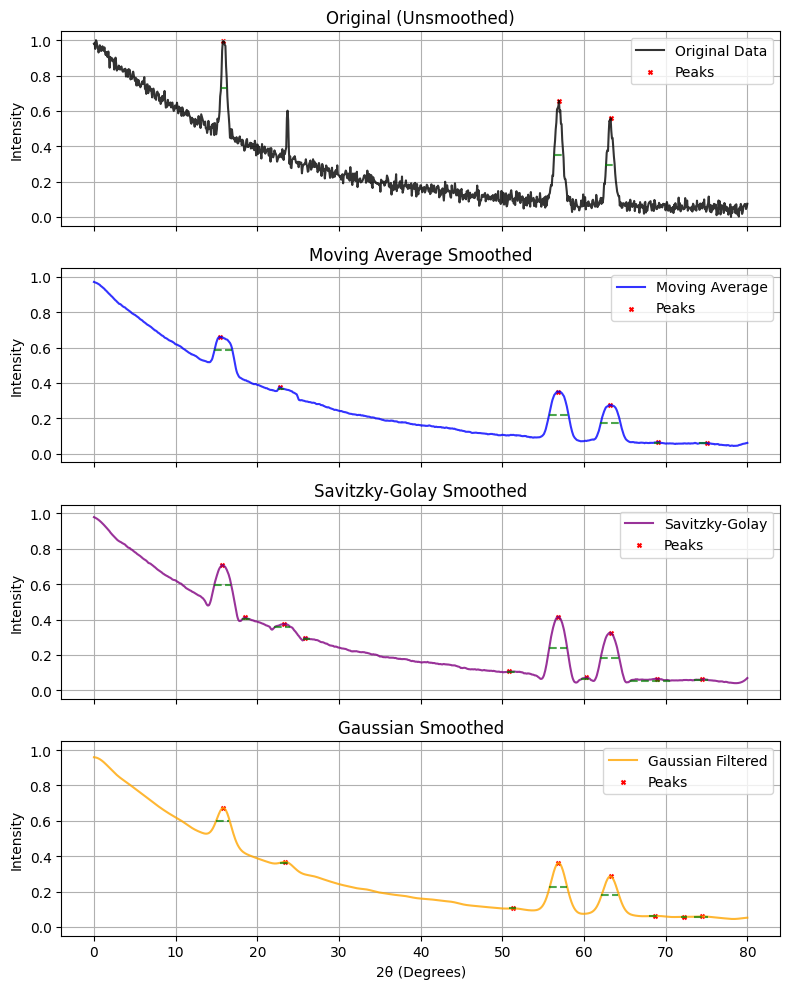

Original Peak Widths: [ 9.37225769 14.12119432 13.21868312]
Moving Average Peak Widths: [26.95160968 10.12033111 29.59528449 30.0807562   9.73064643 13.59013424]
Savitzky-Golay Peak Widths: [26.20862037 11.62234838 23.65859054  9.30472233 14.80976932 27.45185461
 13.46806302 28.31868765 60.25249092 20.59294474]
Gaussian Peak Widths: [20.67330525 12.04466426  9.84142084 26.49213344 26.55567369 17.75569405
  9.07297666 21.23193437]


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths

# Peak detection parameters
peak_threshold = None  # No explicit threshold
min_peak_width = 8      # Minimum width requirement

# Find peaks
peaks_original, peaks_original_properties = find_peaks(data_normalised[0], threshold=peak_threshold, width=min_peak_width)
peaks_ma, peaks_ma_properties = find_peaks(data_smoothed_ma[0], threshold=peak_threshold, width=min_peak_width)
peaks_sg, peaks_sg_properties = find_peaks(data_smoothed_sg[0], threshold=peak_threshold, width=min_peak_width)
peaks_gauss, peaks_gauss_properties = find_peaks(data_smoothed_gauss[0], threshold=peak_threshold, width=min_peak_width)

# Measure peak widths at half prominence
widths_original, width_heights_original, left_ips_original, right_ips_original = peak_widths(data_normalised[0], peaks_original, rel_height=0.5)
widths_ma, width_heights_ma, left_ips_ma, right_ips_ma = peak_widths(data_smoothed_ma[0], peaks_ma, rel_height=0.5)
widths_sg, width_heights_sg, left_ips_sg, right_ips_sg = peak_widths(data_smoothed_sg[0], peaks_sg, rel_height=0.5)
widths_gauss, width_heights_gauss, left_ips_gauss, right_ips_gauss = peak_widths(data_smoothed_gauss[0], peaks_gauss, rel_height=0.5)

# Convert left and right indices to actual x-values
left_x_original = x_vals[left_ips_original.astype(int)]
right_x_original = x_vals[right_ips_original.astype(int)]

left_x_ma = x_vals[left_ips_ma.astype(int)]
right_x_ma = x_vals[right_ips_ma.astype(int)]

left_x_sg = x_vals[left_ips_sg.astype(int)]
right_x_sg = x_vals[right_ips_sg.astype(int)]

left_x_gauss = x_vals[left_ips_gauss.astype(int)]
right_x_gauss = x_vals[right_ips_gauss.astype(int)]

# Create vertically stacked subplots
fig, axes = plt.subplots(4, 1, figsize=(8, 10), sharex=True, sharey=True)

# Plot Original Data with Peaks
axes[0].plot(x_vals, data_normalised[0], color='black', alpha=0.8, label="Original Data")
axes[0].scatter(x_vals[peaks_original], data_normalised[0][peaks_original], color='red', marker='x', label='Peaks', s=8)
axes[0].hlines(y=width_heights_original, xmin=left_x_original, xmax=right_x_original, color='green', linestyle='--', alpha=0.7)
axes[0].set_title('Original (Unsmoothed)')
axes[0].set_ylabel('Intensity')
axes[0].legend()
axes[0].grid()

# Plot Moving Average Smoothed Data
axes[1].plot(x_vals, data_smoothed_ma[0], color='blue', alpha=0.8, label="Moving Average")
axes[1].scatter(x_vals[peaks_ma], data_smoothed_ma[0][peaks_ma], color='red', marker='x', label='Peaks', s=8)
axes[1].hlines(y=width_heights_ma, xmin=left_x_ma, xmax=right_x_ma, color='green', linestyle='--', alpha=0.7)
axes[1].set_title('Moving Average Smoothed')
axes[1].set_ylabel('Intensity')
axes[1].legend()
axes[1].grid()

# Plot Savitzky-Golay Smoothed Data
axes[2].plot(x_vals, data_smoothed_sg[0], color='purple', alpha=0.8, label="Savitzky-Golay")
axes[2].scatter(x_vals[peaks_sg], data_smoothed_sg[0][peaks_sg], color='red', marker='x', label='Peaks', s=8)
axes[2].hlines(y=width_heights_sg, xmin=left_x_sg, xmax=right_x_sg, color='green', linestyle='--', alpha=0.7)
axes[2].set_title('Savitzky-Golay Smoothed')
axes[2].set_ylabel('Intensity')
axes[2].legend()
axes[2].grid()

# Plot Gaussian Smoothed Data
axes[3].plot(x_vals, data_smoothed_gauss[0], color='orange', alpha=0.8, label="Gaussian Filtered")
axes[3].scatter(x_vals[peaks_gauss], data_smoothed_gauss[0][peaks_gauss], color='red', marker='x', label='Peaks', s=8)
axes[3].hlines(y=width_heights_gauss, xmin=left_x_gauss, xmax=right_x_gauss, color='green', linestyle='--', alpha=0.7)
axes[3].set_title('Gaussian Smoothed')
axes[3].set_ylabel('Intensity')
axes[3].legend()
axes[3].grid()

# Final adjustments
plt.xlabel("2θ (Degrees)")
plt.tight_layout()
plt.show()

# Print widths
print(f"Original Peak Widths: {widths_original}")
print(f"Moving Average Peak Widths: {widths_ma}")
print(f"Savitzky-Golay Peak Widths: {widths_sg}")
print(f"Gaussian Peak Widths: {widths_gauss}")


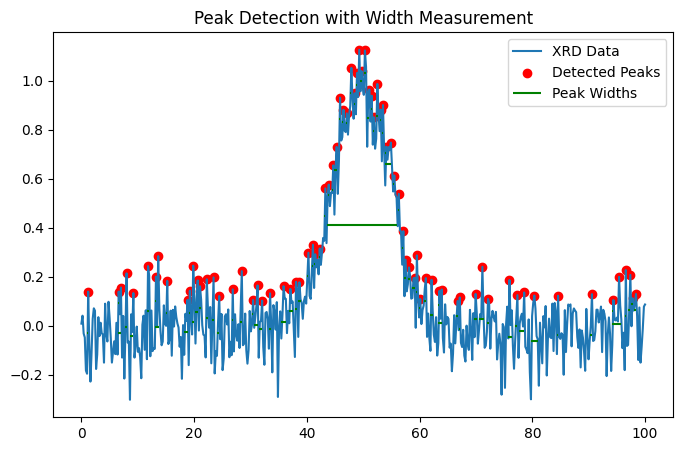

In [ ]:
from scipy.signal import find_peaks, peak_widths
import numpy as np
import matplotlib.pyplot as plt

# Example XRD data (replace with your real dataset)
x = np.linspace(0, 100, 500)
y = np.exp(-((x - 50) ** 2) / (2 * 5**2)) + 0.1 * np.random.randn(len(x))  # Simulated Gaussian peak with noise

# Find peaks
peaks, properties = find_peaks(y, height=0.1, prominence=0.05)

# Measure peak width at half prominence
widths, width_heights, left_ips, right_ips = peak_widths(y, peaks, rel_height=0.5)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(x, y, label="XRD Data")
plt.scatter(x[peaks], y[peaks], color="red", label="Detected Peaks")
plt.hlines(width_heights, x[left_ips.astype(int)], x[right_ips.astype(int)], color="green", label="Peak Widths")
plt.legend()
plt.title("Peak Detection with Width Measurement")
plt.show()
